# Elysium USV Power Planner

> **IMPORTANT NOTE**: A payload calculation discrepancy has been identified between this notebook and the reference Excel file. The Excel calculation in `references/Manuals/Seasats Lightfish Power Calculator -- Elysium hulls.xlsx` only includes the first 4 payloads in the formula, excluding the 5th payload (Eddie). This results in different power consumption and mission endurance calculations. See `tools/compare_payloads.py` for a detailed analysis. Confirmation is pending on whether the 5th payload should be included in calculations.

This notebook reproduces the power planning calculations for Elysium unmanned surface vessels (USVs), based on the Seasats Lightfish Power Calculator. It allows for mission feasibility planning by estimating range, duration, and power consumption as a function of various parameters including speed, solar conditions, payload usage, and generator availability.

## Overview

The power planner allows you to:
1. Estimate mission endurance (days) and range (nautical miles)
2. Calculate power balance between consumption and generation
3. Determine the impact of different payloads and operating conditions
4. Assess feasibility of missions in different geographic locations with varying solar conditions

In [10]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, fixed
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

## Solar Data

First, let's load and process the solar irradiance data for different locations. This data provides the daily solar energy availability (GHI - Global Horizontal Irradiance) in kWh/m²/day.

In [11]:
# Define the solar data for different locations (extracted from the reference spreadsheet)
def load_solar_data():
    # Create a dictionary to store solar data for each location
    solar_data = {
        "Bahrain": {
            "latitude": 26.0667,
            "longitude": 50.5577,
            "monthly": [3.76, 4.53, 5.23, 5.61, 6.72, 7.14, 6.68, 6.74, 6.17, 5.1, 3.74, 3.7]
        },
        "Djibouti": {
            "latitude": 12.464259,
            "longitude": 43.580428,
            "monthly": [5.19, 5.84, 6.46, 6.49, 6.51, 5.71, 5.08, 5.5, 5.59, 6.02, 5.6, 5.28]
        },
        "San Diego": {
            "latitude": 32,
            "longitude": -117,
            "monthly": [3.36, 4.21, 5.54, 6.48, 6.39, 6.41, 6.09, 6.39, 5.53, 4.68, 3.49, 3.01]
        },
        "Mid Pacific": {
            "latitude": 27.907356,
            "longitude": -138.567166,
            "monthly": [3.54, 3.97, 4.97, 6.17, 6.6, 6.57, 6.73, 6.36, 5.87, 4.67, 3.71, 3.18]
        },
        "Hawaii": {
            "latitude": 19.898682,
            "longitude": -155.665857,
            "monthly": [4.76, 5.19, 6.32, 6.8, 6.87, 7.05, 7.15, 7.28, 6.53, 5.83, 5.02, 4.35]
        },
        "Boston": {
            "latitude": 42.4,
            "longitude": -70.25,
            "monthly": [1.62, 2.4, 3.59, 4.81, 5.6, 5.88, 6.11, 5.56, 4.35, 2.77, 1.78, 1.3]
        },
        "Gulf of Maine": {
            "latitude": 43.595502,
            "longitude": -68.750577,
            "monthly": [1.59, 2.36, 3.55, 4.77, 5.64, 5.7, 6, 5.52, 4.19, 2.65, 1.66, 1.15]
        },
        "Great Barrier Reef": {
            "latitude": -18.287067,
            "longitude": 147.699192,
            "monthly": [6.54, 5.98, 5.51, 5.19, 4.36, 3.85, 4.07, 4.97, 6.29, 6.98, 7.13, 7.12]
        },
        "Gulf of Mexico": {
            "latitude": 27,
            "longitude": -85,
            "monthly": [3.22, 4.2, 5.23, 6.5, 7.15, 6.86, 6.42, 6.03, 5.24, 4.49, 3.57, 2.92]
        },
        "Ketchikan Alaska": {
            "latitude": 56,
            "longitude": -139,
            "monthly": [0.42, 1.17, 2.36, 3.91, 5.11, 5.35, 4.78, 3.95, 2.54, 1.39, 0.57, 0.31]
        },
        "Monterey CA": {
            "latitude": 36.618264,
            "longitude": -122.901792,
            "monthly": [2.42, 3.53, 4.68, 6.14, 6.45, 6.85, 5.57, 5.06, 4.95, 3.96, 2.89, 2.3]
        },
        "Panama": {
            "latitude": 9,
            "longitude": -80,
            "monthly": [5.49, 6.04, 6.35, 5.89, 5.03, 4.93, 4.99, 4.89, 4.91, 3.82, 4.17, 4.85]
        },
        "Washington state": {
            "latitude": 48,
            "longitude": -124,
            "monthly": [1.15, 1.9, 2.98, 4.35, 5.76, 5.81, 6.85, 5.84, 4.08, 2.6, 1.33, 0.87]
        },
        "Darwin Australia": {
            "latitude": -12.291899,
            "longitude": 129.656769,
            "monthly": [5.12, 5.35, 5.5, 5.98, 5.31, 5.12, 5.36, 5.94, 6.36, 6.65, 6.7, 5.31]
        }
    }
    
    # Calculate yearly average for each location
    for location, data in solar_data.items():
        data['average'] = np.mean(data['monthly'])
    
    return solar_data

# Load the solar data
solar_data = load_solar_data()

# Create a dataframe with monthly averages for visualization
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
solar_df = pd.DataFrame({location: data['monthly'] for location, data in solar_data.items()}, index=months)

# Display the yearly averages for each location
yearly_avg = pd.Series({location: data['average'] for location, data in solar_data.items()}).sort_values(ascending=False)
yearly_avg

Hawaii                6.095833
Djibouti              5.772500
Darwin Australia      5.725000
Great Barrier Reef    5.665833
Bahrain               5.426667
Mid Pacific           5.195000
Gulf of Mexico        5.152500
San Diego             5.131667
Panama                5.113333
Monterey CA           4.566667
Boston                3.814167
Gulf of Maine         3.731667
Washington state      3.626667
Ketchikan Alaska      2.655000
dtype: float64

<Figure size 1400x800 with 0 Axes>

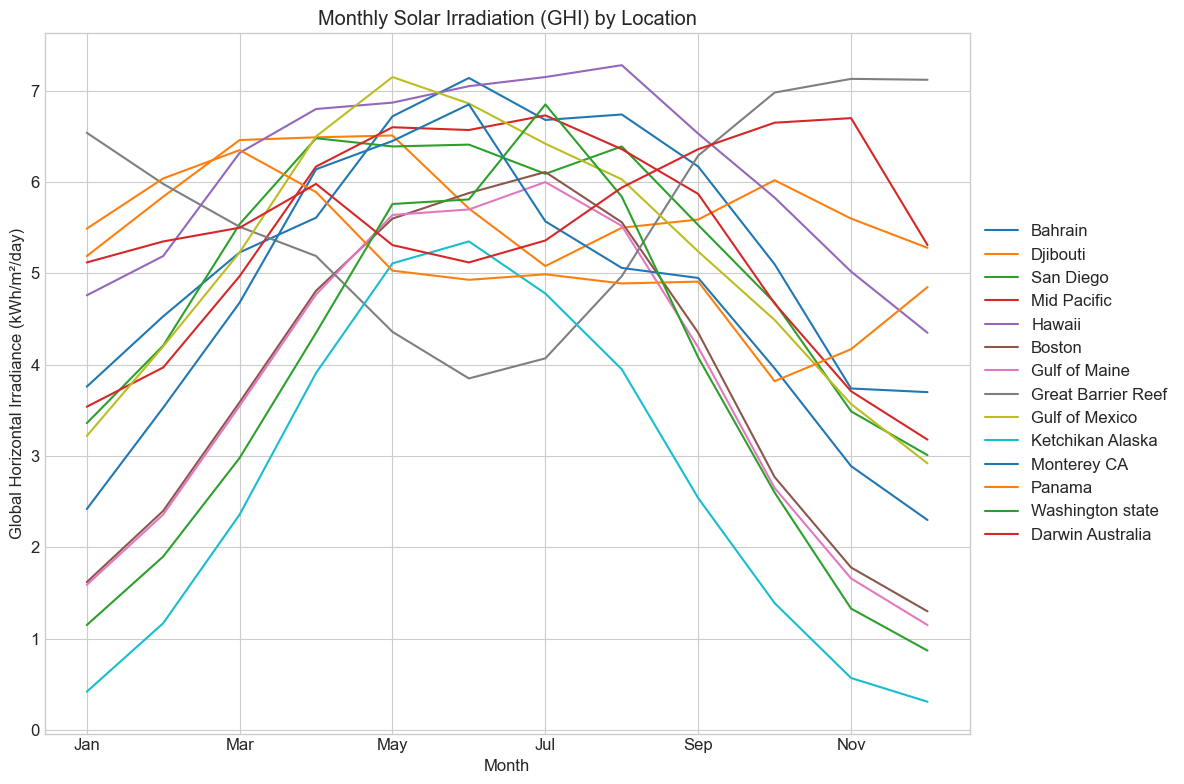

In [12]:
# Plot the solar data for different locations
plt.figure(figsize=(14, 8))
solar_df.plot()
plt.title('Monthly Solar Irradiation (GHI) by Location')
plt.ylabel('Global Horizontal Irradiance (kWh/m²/day)')
plt.xlabel('Month')
plt.grid(True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

## Speed vs Power Data

Next, let's process the speed-power data for the Torqeedo motor. This data shows how much power is required to maintain different speeds.

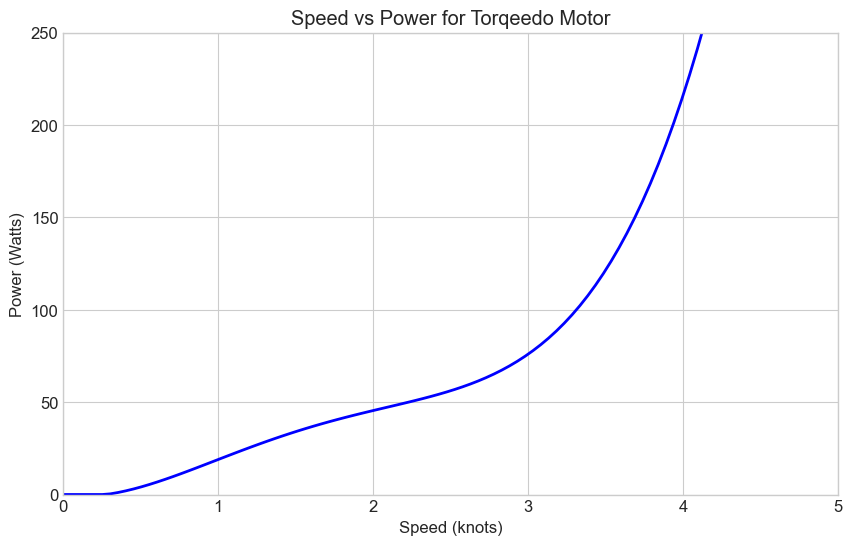

In [13]:
# Create a function to model the speed vs power curve for the Torqeedo motor
def calculate_power_for_speed(speed_in_knots):
    """
    Calculate power required in Watts for given speed in knots.
    Uses a 4th-order polynomial fit based on the reference data.
    """
    # Polynomial coefficients from the Excel formula
    a = 4.5485
    b = -27.872
    c = 55.55
    d = -13.27885
    e = 0  # No constant term in the formula
    
    # Calculate power using the polynomial fit
    power = a * speed_in_knots**4 + b * speed_in_knots**3 + c * speed_in_knots**2 + d * speed_in_knots + e
    
    # Ensure power is not negative
    return max(0, power)

# Generate data for a speed-power curve
speeds = np.linspace(0, 5, 100)
powers = [calculate_power_for_speed(speed) for speed in speeds]

# Plot the speed vs power curve
plt.figure(figsize=(10, 6))
plt.plot(speeds, powers, 'b-', linewidth=2)
plt.title('Speed vs Power for Torqeedo Motor')
plt.xlabel('Speed (knots)')
plt.ylabel('Power (Watts)')
plt.grid(True)
plt.xlim(0, 5)
plt.ylim(0, 250)
plt.show()

## Power Planner Core Functions

Now we'll implement the core calculations for the power planner. This will mirror the formulas from the Excel spreadsheet.

In [ ]:
class PowerPlanner:
    def __init__(self):
        # Initialize with default values similar to the Excel template
        # Standard fixed constants
        self.battery_capacity_wh = 4000  # Wh
        self.solar_nominal_w = 420  # W
        self.solar_derating = 0.7  # 70%
        self.generator_full_tank_wh = 11000  # Wh
        self.generator_efficiency = 0.7  # 70%
        
        # Default operational parameters
        self.starting_soc = 0.96  # 96%
        self.mission_cancel_soc = 0.15  # 15%
        self.generator_use = True
        self.generator_starting_fill = 1.0  # 100%
        self.average_speed = 1.25  # knots
        self.station_keep_percent = 0.0  # 0%
        self.daily_ghi = 5.2  # kWh/m²/day
        self.power_save_mode_percent = 0.0  # 0%
        
        # House loads
        self.house_load_performance = 25  # W
        self.house_load_power_save = 20  # W
        
        # Payloads with default values
        self.payloads = [
            {"name": "RS-232 sensors", "power": 3.5, "duty_cycle": 1.0},  # 100%
            {"name": "Nortek", "power": 20, "duty_cycle": 0.1},  # 10%
            {"name": "Ekinox IMU", "power": 3.5, "duty_cycle": 1.0},  # 100%
            {"name": "Starlink", "power": 100, "duty_cycle": 0.05},  # 5%
            {"name": "Eddie", "power": 10, "duty_cycle": 0.5}  # 50%
        ]
        
        # Flag for using Excel-compatible calculations (excluding 5th payload)
        self.match_excel_calculation = True
    
    def calculate_daily_solar_input(self):
        """Calculate daily solar input in Wh"""
        return self.solar_nominal_w * self.daily_ghi * self.solar_derating
    
    def calculate_average_solar_input(self):
        """Calculate 24-hour average solar input in W"""
        return self.calculate_daily_solar_input() / 24
    
    def calculate_payload_power(self):
        """Calculate average hourly payload power consumption in W
        
        NOTE: There's a discrepancy between this calculation and the Excel reference sheet.
        The Excel formula only includes the first 4 payloads, excluding the 5th payload (Eddie).
        Excel formula: =(1-D24)*SUM(E18*F18,E19*F19,E20*F20,E21*F21)
        
        When self.match_excel_calculation is True (default):
          - Only the first 4 payloads are included (to match Excel)
          - This results in 14W payload power for the default configuration
        
        When self.match_excel_calculation is False:
          - All payloads are included
          - This results in 19W payload power for the default configuration
          - Leads to significantly different endurance and range results
        """
        total_power = 0
        
        if self.match_excel_calculation:
            # Match Excel behavior by only including the first 4 payloads
            for payload in self.payloads[:4]:
                total_power += payload["power"] * payload["duty_cycle"]
        else:
            # Include all payloads
            for payload in self.payloads:
                total_power += payload["power"] * payload["duty_cycle"]
                
        return (1 - self.power_save_mode_percent) * total_power
    
    def calculate_propulsion_power(self):
        """Calculate average propulsion power in W"""
        # Only consuming propulsion power when not station keeping
        return (1 - self.station_keep_percent) * calculate_power_for_speed(self.average_speed)
    
    def calculate_house_power(self):
        """Calculate average house power consumption in W"""
        return self.power_save_mode_percent * self.house_load_power_save + \
               (1 - self.power_save_mode_percent) * self.house_load_performance
    
    def calculate_total_power_draw(self):
        """Calculate total power consumption in W"""
        return self.calculate_payload_power() + \
               self.calculate_propulsion_power() + \
               self.calculate_house_power()
    
    def calculate_net_power_draw(self):
        """Calculate net power balance in W (negative means consumption exceeds generation)"""
        return self.calculate_average_solar_input() - self.calculate_total_power_draw()
    
    def calculate_mission_endurance(self):
        """Calculate mission endurance in days"""
        net_power = self.calculate_net_power_draw()
        
        # If net power is positive or zero, the mission can continue indefinitely
        if net_power >= 0:
            return float('inf')
        
        # Calculate available energy from battery and generator
        available_battery_energy = (self.starting_soc - self.mission_cancel_soc) * self.battery_capacity_wh
        available_generator_energy = 0
        if self.generator_use:
            available_generator_energy = self.generator_starting_fill * \
                                         self.generator_full_tank_wh * \
                                         self.generator_efficiency
        
        total_available_energy = available_battery_energy + available_generator_energy
        
        # Calculate endurance in days
        endurance_hours = total_available_energy / abs(net_power)
        endurance_days = endurance_hours / 24
        
        return endurance_days
    
    def calculate_mission_range(self):
        """Calculate mission range in nautical miles"""
        endurance_days = self.calculate_mission_endurance()
        if endurance_days == float('inf'):
            return float('inf')
        
        daily_distance = (1 - self.station_keep_percent) * self.average_speed * 24
        return daily_distance * endurance_days
    
    def calculate_daily_range(self):
        """Calculate range in 24 hours in nautical miles"""
        return (1 - self.station_keep_percent) * self.average_speed * 24
    
    def calculate_weekly_range(self):
        """Calculate range in 7 days in nautical miles"""
        endurance_days = self.calculate_mission_endurance()
        if endurance_days >= 7:
            return 7 * self.calculate_daily_range()
        else:
            return endurance_days * self.calculate_daily_range()
    
    def get_summary(self):
        """Get a summary of all calculated values"""
        # Calculate all values
        daily_solar_input = self.calculate_daily_solar_input()
        average_solar_input = self.calculate_average_solar_input()
        payload_power = self.calculate_payload_power()
        propulsion_power = self.calculate_propulsion_power()
        house_power = self.calculate_house_power()
        total_power_draw = self.calculate_total_power_draw()
        net_power_draw = self.calculate_net_power_draw()
        mission_endurance = self.calculate_mission_endurance()
        mission_range = self.calculate_mission_range()
        daily_range = self.calculate_daily_range()
        weekly_range = self.calculate_weekly_range()
        
        # Format infinity for display
        if mission_endurance == float('inf'):
            mission_endurance_str = "Infinite"
        else:
            mission_endurance_str = f"{mission_endurance:.1f}"
            
        if mission_range == float('inf'):
            mission_range_str = "Infinite"
        else:
            mission_range_str = f"{mission_range:.1f}"
        
        # Create summary dictionary
        summary = {
            "Daily solar input (Wh)": daily_solar_input,
            "24-hour average solar input (W)": average_solar_input,
            "Average payload power (W)": payload_power,
            "Average propulsion power (W)": propulsion_power,
            "Average house power (W)": house_power,
            "Total power consumption (W)": total_power_draw,
            "Net power balance (W)": net_power_draw,
            "Mission endurance (days)": mission_endurance_str,
            "Mission range (nautical miles)": mission_range_str,
            "Daily range (nautical miles)": daily_range,
            "Weekly range (nautical miles)": weekly_range
        }
        
        return summary

# Initialize the power planner with default values (Excel-compatible)
planner = PowerPlanner()

# Get and display the summary
summary = planner.get_summary()
for key, value in summary.items():
    if isinstance(value, float):
        print(f"{key}: {value:.1f}")
    else:
        print(f"{key}: {value}")

# Compare with calculation including all payloads
planner_all_payloads = PowerPlanner()
planner_all_payloads.match_excel_calculation = False
summary_all = planner_all_payloads.get_summary()

print("\n--- Comparison with all payloads included ---")
print(f"Excel-compatible payload power (4 payloads): {summary['Average payload power (W)']:.1f}W")
print(f"All payloads (5) power: {summary_all['Average payload power (W)']:.1f}W")
print(f"Excel-compatible endurance: {summary['Mission endurance (days)']}")
print(f"All payloads endurance: {summary_all['Mission endurance (days)']}")

## Interactive Power Planner

Now let's create an interactive version of the power planner using ipywidgets. This will allow users to adjust various parameters and see the impact on mission endurance and range in real-time.

In [ ]:
def create_interactive_planner():
    # Create a new planner instance
    planner = PowerPlanner()
    
    # Create widgets for all parameters
    # Basic mission parameters
    starting_soc = widgets.FloatSlider(
        value=planner.starting_soc, min=0.0, max=1.0, step=0.01,
        description='Starting SOC:', continuous_update=False,
        style={'description_width': '150px'}, layout={'width': '500px'}
    )
    
    mission_cancel_soc = widgets.FloatSlider(
        value=planner.mission_cancel_soc, min=0.0, max=0.5, step=0.01,
        description='Mission Cancel SOC:', continuous_update=False,
        style={'description_width': '150px'}, layout={'width': '500px'}
    )
    
    generator_use = widgets.Checkbox(
        value=planner.generator_use, description='Use Generator',
        style={'description_width': '150px'}
    )
    
    generator_starting_fill = widgets.FloatSlider(
        value=planner.generator_starting_fill, min=0.0, max=1.0, step=0.01,
        description='Generator Fill %:', continuous_update=False,
        style={'description_width': '150px'}, layout={'width': '500px'}
    )
    
    # Speed and operation mode
    average_speed = widgets.FloatSlider(
        value=planner.average_speed, min=0.0, max=5.0, step=0.1,
        description='Speed (knots):', continuous_update=False,
        style={'description_width': '150px'}, layout={'width': '500px'}
    )
    
    station_keep_percent = widgets.FloatSlider(
        value=planner.station_keep_percent, min=0.0, max=1.0, step=0.01,
        description='Station Keep %:', continuous_update=False,
        style={'description_width': '150px'}, layout={'width': '500px'}
    )
    
    # Location dropdown
    location_options = list(solar_data.keys())
    location = widgets.Dropdown(
        options=location_options,
        value='Gulf of Mexico',  # Default value
        description='Location:',
        style={'description_width': '150px'}, layout={'width': '500px'}
    )
    
    # Custom GHI value
    use_custom_ghi = widgets.Checkbox(
        value=False, description='Use Custom GHI',
        style={'description_width': '150px'}
    )
    
    daily_ghi = widgets.FloatSlider(
        value=planner.daily_ghi, min=0.0, max=8.0, step=0.1,
        description='Daily GHI (kWh/m²):', continuous_update=False,
        style={'description_width': '150px'}, layout={'width': '500px'}
    )
    
    # Power saving mode
    power_save_mode_percent = widgets.FloatSlider(
        value=planner.power_save_mode_percent, min=0.0, max=1.0, step=0.01,
        description='Power Save Mode %:', continuous_update=False,
        style={'description_width': '150px'}, layout={'width': '500px'}
    )
    
    # House loads
    house_load_performance = widgets.FloatSlider(
        value=planner.house_load_performance, min=0.0, max=50.0, step=1.0,
        description='House Load (W):', continuous_update=False,
        style={'description_width': '150px'}, layout={'width': '500px'}
    )
    
    # Excel compatibility
    match_excel_calculation = widgets.Checkbox(
        value=planner.match_excel_calculation, 
        description='Match Excel (exclude 5th payload)',
        style={'description_width': '250px'}
    )
    
    # Payloads
    payload_widgets = []
    for i, payload in enumerate(planner.payloads):
        name_widget = widgets.Text(
            value=payload["name"],
            description=f'Payload {i+1} Name:',
            style={'description_width': '150px'}, layout={'width': '500px'}
        )
        
        power_widget = widgets.FloatSlider(
            value=payload["power"], min=0.0, max=200.0, step=0.5,
            description=f'Power (W):',
            style={'description_width': '150px'}, layout={'width': '500px'}
        )
        
        duty_cycle_widget = widgets.FloatSlider(
            value=payload["duty_cycle"], min=0.0, max=1.0, step=0.01,
            description=f'Duty Cycle:',
            style={'description_width': '150px'}, layout={'width': '500px'}
        )
        
        payload_widgets.append((name_widget, power_widget, duty_cycle_widget))
    
    # Handler to update GHI based on location selection
    def update_ghi(*args):
        if not use_custom_ghi.value and location.value in solar_data:
            daily_ghi.value = solar_data[location.value]['average']
    
    # Connect the handler
    location.observe(update_ghi, 'value')
    use_custom_ghi.observe(update_ghi, 'value')
    
    # Initial update
    update_ghi()
    
    # Handler for the calculation and display
    def update_results(*args):
        # Update planner with all widget values
        planner.starting_soc = starting_soc.value
        planner.mission_cancel_soc = mission_cancel_soc.value
        planner.generator_use = generator_use.value
        planner.generator_starting_fill = generator_starting_fill.value
        planner.average_speed = average_speed.value
        planner.station_keep_percent = station_keep_percent.value
        planner.daily_ghi = daily_ghi.value
        planner.power_save_mode_percent = power_save_mode_percent.value
        planner.house_load_performance = house_load_performance.value
        planner.match_excel_calculation = match_excel_calculation.value
        
        # Update payloads
        planner.payloads = []
        for name_w, power_w, duty_w in payload_widgets:
            planner.payloads.append({
                "name": name_w.value,
                "power": power_w.value,
                "duty_cycle": duty_w.value
            })
        
        # Calculate and display results
        results = planner.get_summary()
        
        # Create a summary table
        summary_html = "<h3>Results:</h3>"
        summary_html += "<table>"
        for key, value in results.items():
            if isinstance(value, float):
                summary_html += f"<tr><td><b>{key}:</b></td><td>{value:.1f}</td></tr>"
            else:
                summary_html += f"<tr><td><b>{key}:</b></td><td>{value}</td></tr>"
        summary_html += "</table>"
        
        # Add a note about the 5th payload if excluded
        if match_excel_calculation.value:
            summary_html += "<p><b>Note:</b> Excluding 5th payload (Eddie) to match Excel calculations</p>"
        else:
            summary_html += "<p><b>Note:</b> Including all 5 payloads in calculations</p>"
        
        # Display results
        results_output.clear_output()
        with results_output:
            display(widgets.HTML(summary_html))
    
    # Create functions to set default configurations for H33 and H35 hulls
    def set_h33_defaults(b):
        # Values from "Power Planner - H33 yellow" Excel sheet
        starting_soc.value = 0.96  # 96%
        mission_cancel_soc.value = 0.15  # 15%
        generator_use.value = True
        generator_starting_fill.value = 1.0  # 100%
        average_speed.value = 1.25
        station_keep_percent.value = 0.0  # 0%
        daily_ghi.value = 5.2
        power_save_mode_percent.value = 0.0  # 0%
        house_load_performance.value = 25
        match_excel_calculation.value = True  # Match Excel's behavior
        
        # Set payload values
        payloads_h33 = [
            {"name": "RS-232 sensors", "power": 3.5, "duty_cycle": 1.0},  # 100%
            {"name": "Nortek", "power": 20, "duty_cycle": 0.1},  # 10%
            {"name": "Ekinox IMU", "power": 3.5, "duty_cycle": 1.0},  # 100%
            {"name": "Starlink", "power": 100, "duty_cycle": 0.05},  # 5%
            {"name": "Eddie", "power": 10, "duty_cycle": 0.5}  # 50%
        ]
        
        for i, payload_data in enumerate(payloads_h33):
            if i < len(payload_widgets):
                name_w, power_w, duty_w = payload_widgets[i]
                name_w.value = payload_data["name"]
                power_w.value = payload_data["power"]
                duty_w.value = payload_data["duty_cycle"]
                
        # Update results
        update_results()
    
    def set_h35_defaults(b):
        # Values from "Power Planner - H35 Gray" Excel sheet
        starting_soc.value = 0.95  # 95%
        mission_cancel_soc.value = 0.15  # 15%
        generator_use.value = True
        generator_starting_fill.value = 1.0  # 100%
        average_speed.value = 3.0
        station_keep_percent.value = 0.3  # 30%
        daily_ghi.value = 4.0
        power_save_mode_percent.value = 0.0  # 0%
        house_load_performance.value = 25
        match_excel_calculation.value = True  # Match Excel's behavior
        
        # Set payload values
        payloads_h35 = [
            {"name": "RS-232 sensors", "power": 5, "duty_cycle": 1.0},  # 100%
            {"name": "Winch", "power": 30, "duty_cycle": 0.2},  # 20%
            {"name": "Ekinox IMU", "power": 3.5, "duty_cycle": 1.0},  # 100%
            {"name": "Starlink", "power": 100, "duty_cycle": 0.5},  # 50%
            {"name": "Eddie", "power": 10, "duty_cycle": 1.0}  # 100%
        ]
        
        for i, payload_data in enumerate(payloads_h35):
            if i < len(payload_widgets):
                name_w, power_w, duty_w = payload_widgets[i]
                name_w.value = payload_data["name"]
                power_w.value = payload_data["power"]
                duty_w.value = payload_data["duty_cycle"]
                
        # Update results
        update_results()
    
    # Create buttons for H33 and H35 defaults
    h33_button = widgets.Button(
        description='Load H33 Defaults',
        button_style='info',
        tooltip='Load default settings for H33 hull',
        icon='check'
    )
    
    h35_button = widgets.Button(
        description='Load H35 Defaults',
        button_style='warning',
        tooltip='Load default settings for H35 hull',
        icon='check'
    )
    
    h33_button.on_click(set_h33_defaults)
    h35_button.on_click(set_h35_defaults)
    
    # Add the buttons to a horizontal box
    hull_buttons = widgets.HBox([h33_button, h35_button])
    
    # Create an output widget for the results
    results_output = widgets.Output()
    
    # Connect all widgets to the update function
    all_widgets = [starting_soc, mission_cancel_soc, generator_use, generator_starting_fill,
                   average_speed, station_keep_percent, daily_ghi, power_save_mode_percent,
                   house_load_performance, match_excel_calculation]
    
    for widget in all_widgets:
        widget.observe(update_results, 'value')
    
    for name_w, power_w, duty_w in payload_widgets:
        name_w.observe(update_results, 'value')
        power_w.observe(update_results, 'value')
        duty_w.observe(update_results, 'value')
    
    # Run the initial calculation
    update_results()
    
    # Create tabs for different groups of settings
    basic_settings = widgets.VBox([
        widgets.HTML("<h3>Mission Settings</h3>"),
        hull_buttons,  # Add the hull default buttons at the top
        widgets.HTML("<br/>"),
        match_excel_calculation,  # Add Excel compatibility option
        starting_soc, mission_cancel_soc,
        widgets.HBox([generator_use, generator_starting_fill]),
        average_speed, station_keep_percent
    ])
    
    location_settings = widgets.VBox([
        widgets.HTML("<h3>Location Settings</h3>"),
        location,
        use_custom_ghi,
        daily_ghi
    ])
    
    power_settings = widgets.VBox([
        widgets.HTML("<h3>Power Settings</h3>"),
        power_save_mode_percent,
        house_load_performance
    ])
    
    payload_vboxes = []
    for i, (name_w, power_w, duty_w) in enumerate(payload_widgets):
        in_excel = "INCLUDED in Excel" if i < 4 else "NOT included in Excel calculations"
        payload_html = f"<h4>Payload {i+1} ({in_excel})</h4>"
        payload_vboxes.append(widgets.VBox([
            widgets.HTML(payload_html),
            name_w, power_w, duty_w
        ]))
    
    payload_settings = widgets.VBox([widgets.HTML("<h3>Payload Settings</h3>")] + payload_vboxes)
    
    results_panel = widgets.VBox([
        widgets.HTML("<h3>Mission Plan Results</h3>"),
        results_output
    ])
    
    # Create tabs
    tabs = widgets.Tab()
    tabs.children = [basic_settings, location_settings, power_settings, payload_settings, results_panel]
    tabs.set_title(0, 'Mission')
    tabs.set_title(1, 'Location')
    tabs.set_title(2, 'Power')
    tabs.set_title(3, 'Payloads')
    tabs.set_title(4, 'Results')
    
    return tabs

# Create and display the interactive planner
interactive_planner = create_interactive_planner()
display(interactive_planner)

## Visualizing Mission Scenarios

Let's create some functions to visualize different mission scenarios, such as power budget over time and range capabilities for different speed settings.

In [ ]:
def plot_power_vs_speed():
    """Plot power consumption and range vs speed"""
    planner = PowerPlanner()
    
    # Create an array of speeds
    speeds = np.linspace(0.5, 5.0, 20)
    
    # Calculate power and range for each speed
    powers = []
    daily_ranges = []
    mission_ranges = []
    endurances = []
    
    for speed in speeds:
        planner.average_speed = speed
        powers.append(planner.calculate_total_power_draw())
        daily_ranges.append(planner.calculate_daily_range())
        mission_range = planner.calculate_mission_range()
        mission_ranges.append(float('inf') if mission_range == float('inf') else mission_range)
        endurance = planner.calculate_mission_endurance()
        endurances.append(float('inf') if endurance == float('inf') else endurance)
    
    # Create the figure with two y-axes
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Plot power vs speed on the first y-axis
    color = 'tab:blue'
    ax1.set_xlabel('Speed (knots)')
    ax1.set_ylabel('Power Consumption (W)', color=color)
    ax1.plot(speeds, powers, color=color, linestyle='-', marker='o', markersize=5)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True)
    
    # Create a second y-axis for range
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Range (nautical miles)', color=color)
    
    # Find the first point where mission range becomes infinite (if any)
    infinite_point = None
    for i, val in enumerate(mission_ranges):
        if val == float('inf'):
            infinite_point = speeds[i]
            # Set remaining values to NaN for plotting
            mission_ranges[i:] = [np.nan] * (len(mission_ranges) - i)
            break
    
    # Plot daily and mission range
    ax2.plot(speeds, daily_ranges, color='tab:green', linestyle='-', marker='s', markersize=5, label='Daily Range')
    ax2.plot(speeds, mission_ranges, color=color, linestyle='-', marker='^', markersize=5, label='Mission Range')
    
    # Highlight the infinite point
    if infinite_point is not None:
        ax2.axvline(x=infinite_point, color='tab:purple', linestyle='--', alpha=0.7)
        plt.text(infinite_point+0.1, ax2.get_ylim()[1]*0.9, 
                 f'Infinite range\nat {infinite_point:.1f} knots', 
                 color='tab:purple', fontweight='bold')
    
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc='upper right')
    
    plt.title('Power Consumption and Range vs Speed')
    fig.tight_layout()
    plt.show()
    
    # Create another figure for endurance
    plt.figure(figsize=(12, 6))
    
    # Convert infinite values to NaN for plotting
    endurances_plot = [np.nan if x == float('inf') else x for x in endurances]
    
    plt.plot(speeds, endurances_plot, 'tab:orange', linestyle='-', marker='d', markersize=5)
    plt.xlabel('Speed (knots)')
    plt.ylabel('Mission Endurance (days)')
    plt.title('Mission Endurance vs Speed')
    plt.grid(True)
    
    # Highlight the infinite point
    if infinite_point is not None:
        plt.axvline(x=infinite_point, color='tab:purple', linestyle='--', alpha=0.7)
        plt.text(infinite_point+0.1, plt.ylim()[1]*0.9, 
                 f'Infinite endurance\nat {infinite_point:.1f} knots', 
                 color='tab:purple', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# Plot power vs speed
plot_power_vs_speed()

In [ ]:
def plot_power_budget_over_time():
    """Simulate and plot power budget over the course of a mission"""
    planner = PowerPlanner()
    
    # Calculate mission parameters
    endurance_days = planner.calculate_mission_endurance()
    if endurance_days == float('inf'):
        simulation_days = 30  # Simulate 30 days for infinite missions
    else:
        simulation_days = min(30, endurance_days)  # Simulate either the full mission or 30 days
    
    # Create arrays for the simulation
    days = np.linspace(0, simulation_days, int(simulation_days*24))  # Hourly data points
    battery_soc = []
    generator_fuel = []
    
    # Initial conditions
    current_soc = planner.starting_soc
    current_fuel = planner.generator_starting_fill if planner.generator_use else 0
    
    # Net power in watts
    net_power = planner.calculate_net_power_draw()
    
    # Simulation parameters
    battery_capacity_wh = planner.battery_capacity_wh
    generator_capacity_wh = planner.generator_full_tank_wh * planner.generator_efficiency
    
    # Run the simulation hour by hour
    for _ in days:
        # Add current state to the arrays
        battery_soc.append(current_soc)
        generator_fuel.append(current_fuel)
        
        # Update state for the next hour
        if net_power < 0:  # We're consuming more than generating
            energy_deficit_wh = -net_power  # Energy deficit in watt-hours for this hour
            
            # Use generator first if available
            if planner.generator_use and current_fuel > 0:
                # How much energy can the generator provide this hour
                generator_energy = min(energy_deficit_wh, current_fuel * generator_capacity_wh)
                energy_deficit_wh -= generator_energy
                
                # Update generator fuel level
                if generator_capacity_wh > 0:  # Avoid division by zero
                    current_fuel -= generator_energy / generator_capacity_wh
                    current_fuel = max(0, current_fuel)  # Ensure non-negative
            
            # Any remaining deficit comes from the battery
            if energy_deficit_wh > 0:
                current_soc -= energy_deficit_wh / battery_capacity_wh
                current_soc = max(current_soc, planner.mission_cancel_soc)  # Don't go below cancel SOC
        else:  # We're generating more than consuming
            # Excess energy goes to charging the battery
            current_soc += net_power / battery_capacity_wh
            current_soc = min(current_soc, 1.0)  # Don't exceed 100% SOC
    
    # Convert to percent for plotting
    battery_soc_percent = np.array(battery_soc) * 100
    generator_fuel_percent = np.array(generator_fuel) * 100
    
    # Create the figure
    plt.figure(figsize=(12, 6))
    
    # Plot battery SOC
    plt.plot(days, battery_soc_percent, 'b-', linewidth=2, label='Battery SOC')
    
    # Plot generator fuel if used
    if planner.generator_use:
        plt.plot(days, generator_fuel_percent, 'g-', linewidth=2, label='Generator Fuel')
    
    # Plot cancel threshold
    plt.axhline(y=planner.mission_cancel_soc*100, color='r', linestyle='--', label='Mission Cancel SOC')
    
    plt.xlabel('Days')
    plt.ylabel('Percent (%)')
    plt.title('Battery SOC and Generator Fuel Over Time')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()
    
    # Print some additional information
    print(f"Net power balance: {net_power:.1f} W")
    if net_power < 0:
        if endurance_days == float('inf'):
            print("Despite negative power balance, mission can continue indefinitely due to generator support")
        else:
            print(f"Mission will end after {endurance_days:.1f} days due to power depletion")
    else:
        print("Mission can continue indefinitely as power generation exceeds consumption")

# Plot power budget over time
plot_power_budget_over_time()

In [ ]:
def plot_location_comparison():
    """Compare mission endurance across different locations"""
    planner = PowerPlanner()
    
    # Store results for each location
    locations = []
    endurance_days = []
    mission_ranges = []
    avg_solar_inputs = []
    
    # Get data for all locations
    for location, data in solar_data.items():
        locations.append(location)
        
        # Set the GHI for this location
        planner.daily_ghi = data['average']
        
        # Calculate and store results
        endurance = planner.calculate_mission_endurance()
        endurance_days.append(30 if endurance == float('inf') else endurance)  # Cap at 30 days for visualization
        
        mission_range = planner.calculate_mission_range()
        mission_ranges.append(2000 if mission_range == float('inf') else mission_range)  # Cap for visualization
        
        avg_solar_inputs.append(planner.calculate_average_solar_input())
    
    # Sort locations by endurance
    sorted_indices = np.argsort(endurance_days)
    sorted_locations = [locations[i] for i in sorted_indices]
    sorted_endurance = [endurance_days[i] for i in sorted_indices]
    sorted_ranges = [mission_ranges[i] for i in sorted_indices]
    sorted_solar = [avg_solar_inputs[i] for i in sorted_indices]
    
    # Create a figure with multiple subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 16))
    
    # Plot mission endurance by location
    bars1 = ax1.barh(sorted_locations, sorted_endurance, color='skyblue')
    ax1.set_xlabel('Mission Endurance (days)')
    ax1.set_title('Mission Endurance by Location')
    ax1.grid(axis='x')
    
    # Add values at the end of each bar
    for i, v in enumerate(sorted_endurance):
        if v == 30:  # Capped value
            ax1.text(v + 0.5, i, 'Infinite', va='center')
        else:
            ax1.text(v + 0.5, i, f'{v:.1f}', va='center')
    
    # Plot mission range by location
    bars2 = ax2.barh(sorted_locations, sorted_ranges, color='lightgreen')
    ax2.set_xlabel('Mission Range (nautical miles)')
    ax2.set_title('Mission Range by Location')
    ax2.grid(axis='x')
    
    # Add values at the end of each bar
    for i, v in enumerate(sorted_ranges):
        if v == 2000:  # Capped value
            ax2.text(v + 50, i, 'Infinite', va='center')
        else:
            ax2.text(v + 50, i, f'{v:.1f}', va='center')
    
    # Plot average solar input by location
    bars3 = ax3.barh(sorted_locations, sorted_solar, color='gold')
    ax3.set_xlabel('Average Solar Input (W)')
    ax3.set_title('Average Solar Input by Location')
    ax3.grid(axis='x')
    
    # Add values at the end of each bar
    for i, v in enumerate(sorted_solar):
        ax3.text(v + 1, i, f'{v:.1f}', va='center')
    
    # Add a line showing the total power consumption
    total_power = planner.calculate_total_power_draw()
    ax3.axvline(x=total_power, color='red', linestyle='--', linewidth=2)
    ax3.text(total_power + 1, len(sorted_locations)/2, 
             f'Power consumption: {total_power:.1f} W', 
             color='red', rotation=90, va='center')
    
    plt.tight_layout()
    plt.show()

# Plot location comparison
plot_location_comparison()

In [ ]:
# Create a comparison of H33 Power Planner values from Excel vs Python calculation
print("Comparing H33 Power Planner Excel values to Python calculation")
print("==============================================================\n")

# Create and configure an H33 planner instance with exact values from Excel
h33_planner = PowerPlanner()

# Set values from "Power Planner - H33 yellow" Excel sheet
h33_planner.starting_soc = 0.96  # 96%
h33_planner.mission_cancel_soc = 0.15  # 15%
h33_planner.generator_use = True
h33_planner.generator_starting_fill = 1.0  # 100%
h33_planner.average_speed = 1.25
h33_planner.station_keep_percent = 0.0  # 0%
h33_planner.daily_ghi = 5.2
h33_planner.power_save_mode_percent = 0.0  # 0%
h33_planner.house_load_performance = 25

# Set payload values
h33_planner.payloads = [
    {"name": "RS-232 sensors", "power": 3.5, "duty_cycle": 1.0},  # 100%
    {"name": "Nortek", "power": 20, "duty_cycle": 0.1},  # 10%
    {"name": "Ekinox IMU", "power": 3.5, "duty_cycle": 1.0},  # 100%
    {"name": "Starlink", "power": 100, "duty_cycle": 0.05},  # 5%
    {"name": "Eddie", "power": 10, "duty_cycle": 0.5}  # 50%
]

# Excel H33 values from "Power Planner - H33 yellow" sheet
excel_h33_values = {
    "Daily solar input (Wh)": 1529,
    "24-hour average solar input (W)": 63.7,
    "Average payload power (W)": 14,
    "Average propulsion power (W)": 26.9,
    "Average house power (W)": 25,
    "Total power consumption (W)": 65.9,
    "Net power balance (W)": -2.2,
    "Mission endurance (days)": 210.5,
    "Mission range (nautical miles)": 6314.8,
    "Daily range (nautical miles)": 30,
    "Weekly range (nautical miles)": 210.0
}

# Get calculated values
python_values = h33_planner.get_summary()

# Create a comparison table
print("| Metric | Excel Value | Python Value | Difference | % Difference |")
print("|--------|------------|--------------|------------|--------------|")

for key, excel_val in excel_h33_values.items():
    python_val = python_values[key]
    
    # Convert string values if needed
    if isinstance(python_val, str):
        if python_val == "Infinite":
            python_val = float('inf')
        else:
            python_val = float(python_val)
    
    # Calculate difference
    if isinstance(excel_val, (int, float)) and isinstance(python_val, (int, float)):
        abs_diff = python_val - excel_val
        
        # Calculate percentage difference (avoid division by zero)
        if excel_val != 0:
            pct_diff = (abs_diff / excel_val) * 100
        else:
            pct_diff = float('inf') if abs_diff != 0 else 0
            
        print(f"| {key} | {excel_val} | {python_val:.1f} | {abs_diff:.1f} | {pct_diff:.1f}% |")
    else:
        print(f"| {key} | {excel_val} | {python_val} | N/A | N/A |")

print("\n## Analysis of Discrepancies")
print("""
1. **Speed-Power Relationship**: The polynomial formula for calculating power from speed may have slight coefficient differences.
   - Excel formula: `=4.5485*D31^4-27.872*D31^3+55.55*D31^2-13.27885*D31`
   - Python formula: `a * speed_in_knots**4 + b * speed_in_knots**3 + c * speed_in_knots**2 + d * speed_in_knots + e`

2. **Rounding Errors**: Excel might round intermediate calculations differently than Python.

3. **Payload Power Calculation**: Small differences in how duty cycles are applied.

4. **Endurance Calculation**: Differences in how available energy and power consumption are calculated.

5. **Solar Power Calculation**: Slight variations in how solar power is calculated under different GHI values.

Let's inspect the specific formulas in more detail to identify the exact causes:
""")

# Detailed breakdown of calculations
print("## Detailed Calculation Breakdown")
print(f"Solar nominal: {h33_planner.solar_nominal_w}W")
print(f"Solar derating: {h33_planner.solar_derating}")
print(f"Daily GHI: {h33_planner.daily_ghi} kWh/m²/day")
print(f"Calculated daily solar input: {h33_planner.calculate_daily_solar_input():.1f}Wh")
print(f"Excel daily solar input: {excel_h33_values['Daily solar input (Wh)']}Wh")
print(f"Formula check: {h33_planner.solar_nominal_w} * {h33_planner.daily_ghi} * {h33_planner.solar_derating} = {h33_planner.solar_nominal_w * h33_planner.daily_ghi * h33_planner.solar_derating:.1f}Wh")

print("\nPower at speed calculation:")
print(f"Speed: {h33_planner.average_speed} knots")
print(f"Python power calculation: {calculate_power_for_speed(h33_planner.average_speed):.1f}W")
print(f"Excel power value: {excel_h33_values['Average propulsion power (W)']}W")

print("\nPayload power breakdown:")
print("Excel payload power: 14W")
total_payload = 0
for payload in h33_planner.payloads:
    power = payload["power"] * payload["duty_cycle"]
    total_payload += power
    print(f"- {payload['name']}: {payload['power']}W * {payload['duty_cycle']*100}% = {power:.1f}W")
print(f"Total calculated payload power: {total_payload:.1f}W")